# <div align="center"><b> Desafio 3 - Procesamiento del lenguaje Natural - CEIA </b></div>


<div align="right">📝 <em><small><font color='Gray'>Nota:</font></small></em></div>

<div align="right"> <em><small><font color='Gray'> La funcionalidad de visualización de jupyter notebooks en <a href="https://github.com/" target="_blank">github</a> es solamente un preview.</font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Para mejor visualización se sugiere utilizar el visualizador recomndado por la comunidad: <a href="https://nbviewer.org/" target="_blank">nbviewer</a></font></small></em> </div>

<div align="right"> <em><small><font color='Gray'> Puedes a acceder al sigiente enlace para ver este notebook en dicha página: <a href="https://nbviewer.org/github/brunomaso1/uba-ceia/blob/ceia-nlp/ceia-nlp/Desafio%203.ipynb">Desafio 3</a></font></small></em> </div>


---


<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>


<div align="center"><img src="./resources/Desafio_3_portada.jpg" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div>

<div align="center"><small><em>Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3</em></small></div>


<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Desafío 3 - NLP - FIUBA               |
| --------------- | ------------------------------------- |
| **Descrpción**  | Model language                        |
| **Integrantes** | Bruno Masoller (brunomaso1@gmail.com) |

</div>


✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋


In [60]:
import pandas as pd
import numpy as np
import os, glob, re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from math import sqrt
import seaborn as sns
from collections import defaultdict

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [82]:
VERBOSE = False  # Si se muestra todo el entrenamiento de Gensim
EPOCHS = 100  # Épocas a entrenar
RANDOM_SEED = 42  # Semilla de random
TRAIN_TEST_SPLIT_RATIO = 0.2

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ferchita-
[nltk_data]     Maso\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Consigna del desafío


### Parte 1 

- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus en palabras, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

### Parte 2 

- Realizar el pre-procesamiento adecuado para tokenizar el corpus en base a carácteres, estructurar el dataset y separar entre datos de entrenamiento y validación.

## Resolución


### Parte 1


> - Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
> - Realizar el pre-procesamiento adecuado para tokenizar el corpus en palabras, estructurar el dataset y separar entre datos de entrenamiento y validación.
> - Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
> - Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

<em><p>

Para este desafío, utilizaremos 5 de las obras de tolkien para generar un modelo del lenguaje. Las obras son:
- La comunidad del anillo
- El hobbit
- El retorno del rey
- Las dos torres
- El silmarillon

</p></em>

*Inicialmente, cargamos los textos. Como estos fueron "extraídos (🏴‍☠️)", los pre-procesamos para eliminar la metadata:*

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Carga los textos de un directorio</p></font></em>

In [62]:
import os
import re
import glob
import pandas as pd

def importar_textos(ruta, textos_validos) -> pd.DataFrame:
    pattern = re.compile(r'([^\\\/]+)(?=\.txt$)')
    data = []
    
    for filename in glob.glob(os.path.join(ruta, '*.txt')):
        # Extraer el nombre del archivo sin la extensión
        file_name = pattern.search(filename).group(0)
        
        if file_name in textos_validos:
            # Abrir el archivo y leer su contenido
            with open(filename, 'r', encoding='utf-8') as f:
                full_text = f.read()
                
                # Obtener los índices para este archivo desde `textos_validos`
                start_idx, end_idx = textos_validos[file_name]
                
                # Extraer el texto entre los índices especificados
                extracted_text = full_text[start_idx:end_idx]
                
                # Dividir el texto por más de un salto de línea
                paragraphs = re.split(r'\n{2,}', extracted_text)
                
                # Agregar cada párrafo como una nueva fila en la lista de datos
                for paragraph in paragraphs:
                    data.append({
                        'file_name': file_name,
                        'extracted_text': paragraph.strip()  # Remover espacios innecesarios
                    })
        else:
            print(f"Archivo {file_name} no está en textos_validos.")

    # Convertir la lista de datos en un DataFrame
    df = pd.DataFrame(data)
    
    return df


*Cargamos los textos en un dataframe:*

In [63]:
# Visualmente nos fijamos desde donde y hasta donde tomar los textos para evitar la meta-data.
textos_validos = {
    'fellowship': (43242, -5436),
    'silmarillion': (43190, -5436),
    'hobbit': (43212, -8543),
    'return': (43252, -5434),
    'twotowers': (43302, -19245)
}

path = './resources/lotr_books/'
df = importar_textos(path, textos_validos)
df

,file_name,extracted_text
0,fellowship,“THE LORD OF THE RINGS'
1,fellowship,Part One
2,fellowship,THE FELLOWSHIP \nOF THE RING
3,fellowship,J.R.R.ToIkien
4,fellowship,Complete Table of Contents
...,...,...
15593,twotowers,THE CHOICES OF MASTER SAMWISE 971
15594,twotowers,"Sam heard a burst of hoarse singing, blaring o..."
15595,twotowers,"Sam yelled and brandished Sting, but his littl..."
15596,twotowers,The great doors slammed to. Boom. The bars of ...


*Nos quedamos solo con los textos:*

In [64]:
df = pd.DataFrame(df['extracted_text'])
df

,extracted_text
0,“THE LORD OF THE RINGS'
1,Part One
2,THE FELLOWSHIP \nOF THE RING
3,J.R.R.ToIkien
4,Complete Table of Contents
...,...
15593,THE CHOICES OF MASTER SAMWISE 971
15594,"Sam heard a burst of hoarse singing, blaring o..."
15595,"Sam yelled and brandished Sting, but his littl..."
15596,The great doors slammed to. Boom. The bars of ...


_Verificamos la información del cojunto:_


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15598 entries, 0 to 15597
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   extracted_text  15598 non-null  object
dtypes: object(1)
memory usage: 122.0+ KB


#### Tokenizar

_Una vez que tenemos todo el script, realizaremos el pre-procesamiento convieriendo los documentos (cada linea) en tokens._


🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'>Realiza el procesamiento de las sentencias utilizando NLTK (https://www.nltk.org/)</font></em>


In [66]:
def nltk_process(text):
    lemmatizer = WordNetLemmatizer()

    # Convertir todo el texto a minúsculas
    filtered_sentence = text.lower()

    # Tokenization
    filtered_sentence = word_tokenize(filtered_sentence)

    # Lemmatization
    # filtered_sentence = [lemmatizer.lemmatize(word) for word in filtered_sentence]

    # Stop words
    nltk_stop_words = stopwords.words("english")
    # filtered_sentence = [w for w in filtered_sentence if w not in nltk_stop_words]

    # Filter Punctuation
    # filtered_sentence = [w for w in filtered_sentence if w not in string.punctuation]

    return filtered_sentence

_Pre-procesamos las sentencias:_


In [67]:
segmented_sentences = []
for _, row in df[:None].iterrows():
    segmented_sentences.append(nltk_process(row.iloc[0]))

_Chequeamos algunas sentencias al azar:_


In [68]:
rng = np.random.default_rng(seed=RANDOM_SEED)

for i in range(5):
    random_index = rng.integers(len(segmented_sentences))
    print(segmented_sentences[random_index])

['the', 'hobbits', 'shuddered', '.', 'even', 'in', 'the', 'shire', 'the', 'rumour', 'of', 'the', 'barrow-', 'wights', 'of', 'the', 'barrow-downs', 'beyond', 'the', 'forest', 'had', 'been', 'heard', '.', 'but', 'it', 'was', 'not', 'a', 'tale', 'that', 'any', 'hobbit', 'liked', 'to', 'listen', 'to', ',', 'even', 'by', 'a', 'comfortable', 'fireside', 'far', 'away', '.', 'these', 'four', 'now', 'suddenly', 'remembered', 'what', 'the', 'joy', 'of', 'this', 'house', 'had', 'driven', 'from', 'their', 'minds', ':', 'the', 'house', 'of', 'tom', 'bombadil', 'nestled', 'under', 'the', 'very', 'shoulder', 'of', 'those', 'dreaded', 'hills', '.', 'they', 'lost', 'the', 'thread', 'of', 'his', 'tale', 'and', 'shifted', 'uneasily', ',', 'looking', 'aside', 'at', 'one', 'another', '.']
['‘', 'if', 'you', 'wish', 'to', 'know', 'what', 'i', 'think', ',', '’', 'he', 'began', 'again', 'after', 'a', 'while', ',', '‘', 'i', 'think', 'it', 'was', 'saruman', '.', 'who', 'else', '?', 'remember', 'the', 'words', 

_Chequeamos la cantidad de sentencias_


In [69]:
len(segmented_sentences)

15598

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Construye el vocabulario a partir de términos de sentencias</p></font></em>

In [70]:
# Construir el vocabulario (similar a fit_on_texts en Keras)
def build_vocab(segmented_sentences):
    vocab = defaultdict(lambda: 0)  # Índice 0 reservado para OOV
    index = 1  # Comenzamos los índices desde 1, igual que en Keras
    
    for sentence in segmented_sentences:
        for word in sentence:
            if word not in vocab:
                vocab[word] = index
                index += 1
                
    return vocab

🔮 <em><font color='violet'>Función auxiliar:</font></em>
<em><font color='violet'><p>Convierte sentencias en tokens</p></font></em>

In [71]:
# Convertir oraciones en secuencias de números (similar a texts_to_sequences en Keras)
def texts_to_sequences_nltk(segmented_sentences, vocab):
    return [[vocab[word] for word in sentence] for sentence in segmented_sentences]

*Finalmente, creamos el vocabulario y tokenizamos las sentencias segmentadas:*

In [72]:
# Crear vocabulario
vocab = build_vocab(segmented_sentences)

# Convertir las oraciones procesadas en secuencias de números
tokenized_sentences = texts_to_sequences_nltk(segmented_sentences, vocab)

In [73]:
print("Vocabulario:")
dict(vocab)

Vocabulario:


{'“': 1,
 'the': 2,
 'lord': 3,
 'of': 4,
 'rings': 5,
 "'": 6,
 'part': 7,
 'one': 8,
 'fellowship': 9,
 'ring': 10,
 'j.r.r.toikien': 11,
 'complete': 12,
 'table': 13,
 'contents': 14,
 'foreword': 15,
 'prologue': 16,
 '1': 17,
 '.': 18,
 'concerning': 19,
 'hobbits': 20,
 '2.': 21,
 'pipe-weed': 22,
 '3.': 23,
 'ordering': 24,
 'shire': 25,
 '4.': 26,
 'finding': 27,
 'note': 28,
 'on': 29,
 'records': 30,
 'book': 31,
 'i': 32,
 'chapter': 33,
 '2': 34,
 '3': 35,
 '4': 36,
 '5': 37,
 '6': 38,
 '7': 39,
 '8': 40,
 '9': 41,
 '10': 42,
 '11': 43,
 '12': 44,
 'a': 45,
 'long-expected': 46,
 'party': 47,
 'shadow': 48,
 'past': 49,
 'three': 50,
 'is': 51,
 'company': 52,
 'short': 53,
 'cut': 54,
 'to': 55,
 'mushrooms': 56,
 'conspiracy': 57,
 'unmasked': 58,
 'old': 59,
 'forest': 60,
 'in': 61,
 'house': 62,
 'tom': 63,
 'bombadil': 64,
 'fog': 65,
 'barrow-downs': 66,
 'at': 67,
 'sign': 68,
 'prancing': 69,
 'pony': 70,
 'strider': 71,
 'knife': 72,
 'dark': 73,
 'flight': 74,
 

In [74]:
print("Secuencias tokenizadas:")
tokenized_sentences

Secuencias tokenizadas:


[[1, 2, 3, 4, 2, 5, 6],
 [7, 8],
 [2, 9, 4, 2, 10],
 [11],
 [12, 13, 4, 14],
 [15],
 [16],
 [17, 18, 19, 20],
 [21, 19, 22],
 [23, 4, 2, 24, 4, 2, 25],
 [26, 4, 2, 27, 4, 2, 10],
 [28, 29, 2, 25, 30],
 [31, 32],
 [33,
  17,
  33,
  34,
  33,
  35,
  33,
  36,
  33,
  37,
  33,
  38,
  33,
  39,
  33,
  40,
  33,
  41,
  33,
  42,
  33,
  43,
  33,
  44],
 [45,
  46,
  47,
  2,
  48,
  4,
  2,
  49,
  50,
  51,
  52,
  45,
  53,
  54,
  55,
  56,
  45,
  57,
  58,
  2,
  59,
  60],
 [61, 2, 62, 4, 63, 64, 65, 29, 2, 66, 67, 2, 68, 4, 2, 69, 70, 71],
 [45, 72, 61, 2, 73, 74, 55, 2, 75],
 [31, 76],
 [33,
  17,
  33,
  34,
  33,
  35,
  33,
  36,
  33,
  37,
  33,
  38,
  33,
  39,
  33,
  40,
  33,
  41,
  33,
  42],
 [77, 78, 2, 79, 4, 80, 2, 10, 81, 82, 45, 83, 61, 2, 73, 2, 84, 4, 85, 86],
 [2, 87, 4, 88, 89, 55, 90, 2, 91, 92, 2, 93, 4, 2, 9],
 [31, 94],
 [33,
  17,
  33,
  34,
  33,
  35,
  33,
  36,
  33,
  37,
  33,
  38,
  33,
  39,
  33,
  40,
  33,
  41,
  33,
  42,
  33,
  43],

*Observamos una sentencia tokenizada:*

In [75]:
print(f"Sentencia segmentada: {segmented_sentences[0]}")
print(f"Sentencia tokenizada: {tokenized_sentences[0]}")

Sentencia segmentada: ['“', 'the', 'lord', 'of', 'the', 'rings', "'"]
Sentencia tokenizada: [1, 2, 3, 4, 2, 5, 6]


#### Tamaño del contexto

*Obtenemos la longitud de cada sentencia:*

In [76]:
length_sentences = [len(sentence) for sentence in segmented_sentences]

*Vemos la distribución de las sentencias:*

<Axes: ylabel='Count'>

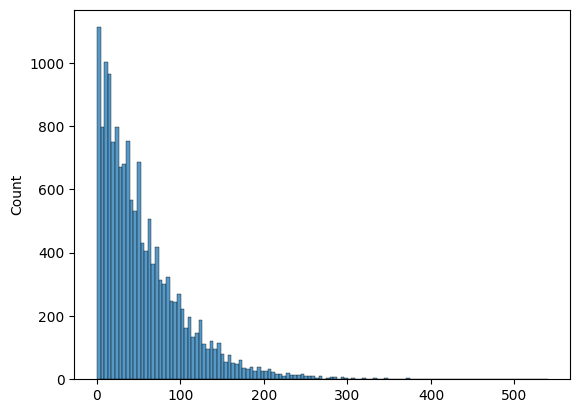

In [77]:
import seaborn as sns

sns.histplot(length_sentences, bins=int(sqrt(len(length_sentences))))

*Elegimos un contexto máximo:*

In [78]:
max_context_size = int(np.percentile(length_sentences, 90)-1)
print(f'max_context_size: {max_context_size}')

max_context_size: 122


#### Modelado y entrenamiento

*Inicialmente, dividimos nuestro conjunto en entrenamiento y validación:*

In [83]:
from sklearn.model_selection import train_test_split


tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=TRAIN_TEST_SPLIT_RATIO, random_state=RANDOM_SEED)

##### Data-augmentation

*Para aumentar la cantidad de datos, generamos más secuencias si son mayores al contexto maximo dividiendolas en sub-secuencias:*

In [94]:
tok_sent = []

for sent in tokenized_sentences_train:
    # si la secuencia tiene más términos que el tamaño de contexto máximo,
    # armo varias sub-secuencias de tamaño máximo
    if len(sent) > (max_context_size + 1):
        extra = len(sent) - (max_context_size + 1) + 1
        for i in range(extra):
            tok_sent.append(sent[i : i + max_context_size + 1])
    else:  # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
        tok_sent.append(sent)

In [95]:
print(f'Cantidad de sentencias tokenizadas aumentadas: {len(tok_sent)}')

Cantidad de sentencias tokenizadas aumentadas: 69979


*Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:*

In [96]:
tok_sent_augm = []

for sent in tok_sent:
    subseq = [sent[: i + 2] for i in range(len(sent) - 1)]

    # Aplicar padding usando nltk.pad_sequence
    padded_subseq = [
        list(
            nltk.pad_sequence(
                seq, max_context_size + 1, pad_left=True, left_pad_symbol=0
            )
        )
        for seq in subseq
    ]

    tok_sent_augm.append(padded_subseq)

*Finalmente concatenamos todas las secuencias:*

In [106]:
# Finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (23,) + inhomogeneous part.

In [108]:
# Generamos todas las sub-secuencias y aplicamos padding con nltk.pad_sequence
tok_sent_augm = []

for sent in tok_sent:
    subseq = [sent[:i+2] for i in range(len(sent)-1)]
    
    # Aplicar padding usando nltk.pad_sequence para cada subsecuencia
    padded_subseq = [
        list(nltk.pad_sequence(seq, max_context_size + 1, pad_left=True, left_pad_symbol=0))
        for seq in subseq
    ]
    
    tok_sent_augm.extend(padded_subseq)  # Aseguramos que todas las subsecuencias estén en una sola lista

# Convertimos la lista de listas a un array de NumPy
train_seqs = np.array(tok_sent_augm)

print("train_seqs shape:", train_seqs.shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7634317,) + inhomogeneous part.

*Estructuramos el problema de aprendizaje en un many-to-many:*

📝 <em><font color='Gray'>Nota:</font></em>
<em><font color='Gray'><p>Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.</p></font></em>

In [84]:
X = tokenized_sentences_train[:, :-1]
y = tokenized_sentences_train[:, 1:]

TypeError: list indices must be integers or slices, not tuple